# DDA 4230 Tutorial 9

## Section 0:  Outline
1. Policy Approximation with Parametrization
2. Policy Gradient


In [1]:
import torch.nn as nn
import torch
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from gridWorldGame import standard_grid, negative_grid,print_values, print_policy

## Section 1: Policy Approximation with Parametrization

### 1.1 Discrete Policy Approximation
When action space is discrete
$$\pi(a|s,\theta)=\frac{\exp(h(a,s,\theta))}{\sum_{a'}\exp(h(a',s,\theta))}$$
where $h(a,s,\theta)$ is the preference function. 

A typical preference function is
$$h(a,s,\theta)=\theta^Tx(a,s)$$
where $x(s,a)$ is the feature vector discussed in TU8.

In [2]:
def softmax(x):
    t = np.exp(x - np.max(x))
    return t / np.sum(t)

def categorical_sample(prob_n):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np.random.rand()).argmax()

In [3]:
class GridDiscretePolicy:
    '''
    Naive Discrete Policy for negative_grid Environment
    '''
    def __init__(self):
        self.theta = np.random.randn(25) / np.sqrt(25)

    def sa2x(self, s, a):
        # x(s,a)
        return np.array([
        s[0] - 1              if a == 'U' else 0,
        s[1] - 1.5            if a == 'U' else 0,
        (s[0]*s[1] - 3)/3     if a == 'U' else 0,
        (s[0]*s[0] - 2)/2     if a == 'U' else 0,
        (s[1]*s[1] - 4.5)/4.5 if a == 'U' else 0,
        1                     if a == 'U' else 0,
        s[0] - 1              if a == 'D' else 0,
        s[1] - 1.5            if a == 'D' else 0,
        (s[0]*s[1] - 3)/3     if a == 'D' else 0,
        (s[0]*s[0] - 2)/2     if a == 'D' else 0,
        (s[1]*s[1] - 4.5)/4.5 if a == 'D' else 0,
        1                     if a == 'D' else 0,
        s[0] - 1              if a == 'L' else 0,
        s[1] - 1.5            if a == 'L' else 0,
        (s[0]*s[1] - 3)/3     if a == 'L' else 0,
        (s[0]*s[0] - 2)/2     if a == 'L' else 0,
        (s[1]*s[1] - 4.5)/4.5 if a == 'L' else 0,
        1                     if a == 'L' else 0,
        s[0] - 1              if a == 'R' else 0,
        s[1] - 1.5            if a == 'R' else 0,
        (s[0]*s[1] - 3)/3     if a == 'R' else 0,
        (s[0]*s[0] - 2)/2     if a == 'R' else 0,
        (s[1]*s[1] - 4.5)/4.5 if a == 'R' else 0,
        1                     if a == 'R' else 0,
        1
      ])

    def select_action(self, s):
        # Given state s, return the selected action
        h_a_s_list = []
        for a in ALL_POSSIBLE_ACTIONS:
            x = self.sa2x(s, a)
            # h(a,s,theta)
            h_a_s = self.theta.dot(x)
            h_a_s_list.append(h_a_s)
        # pi(a|s,theta)
        pi = softmax(h_a_s_list)
        # sample action
        action = categorical_sample(pi)
        return ALL_POSSIBLE_ACTIONS[action]



In [4]:
SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
ALPHA = 0.1
SA2IDX = {}
IDX = 0

grid = negative_grid(step_cost=-0.1)
print("Rewards Map:")
print_values(grid.rewards, grid)

Rewards Map:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


In [5]:
policy=GridDiscretePolicy()
s=(0,1)
for t in range(10):
    a=policy.select_action(s)
    print('(%d,%d), %s'%(s[0],s[1],a),end='->')
    r = grid.move(a)
    s = grid.current_state()
print(s)

(0,1), D->(2,0), D->(2,0), R->(2,1), D->(2,1), R->(2,2), L->(2,1), U->(2,1), L->(2,0), R->(2,1), U->(2, 1)


### Torch Version

In [6]:
class DiscretePolicy(nn.Module):
    def __init__(self, state_dim, action_num, hidden_size=(128, 128), activation='tanh'):
        super().__init__()
        self.is_disc_action = True
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = torch.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

        self.affine_layers = nn.ModuleList()
        last_dim = state_dim
        for nh in hidden_size:
            self.affine_layers.append(nn.Linear(last_dim, nh))
            last_dim = nh

        self.action_head = nn.Linear(last_dim, action_num)
        self.action_head.weight.data.mul_(0.1)
        self.action_head.bias.data.mul_(0.0)

    def forward(self, x):
        for affine in self.affine_layers:
            x = self.activation(affine(x))
        action_prob = torch.softmax(self.action_head(x), dim=1)
        return action_prob

    def select_action(self, x):
        # given feature vector, return action index
        action_prob = self.forward(x)
        action = action_prob.multinomial(1)
        return action


### 1.2 Continuous Policy Approximation
For continuous case, the policy can be defined as the normal probability density over a real-valued scalar action, with mean and standard deviation given by parametric function approximators
$$\pi(a|s,\theta)=\frac{1}{\sigma(s,\theta_{\sigma})\sqrt{2\pi}}\exp\left(-\frac{(a-\mu(s,\theta_{\mu}))^2}{2\sigma(s,\theta_{\sigma})^2}\right)$$
where $\theta=[\theta_{\mu}, \theta_{\sigma}]$.

A typical function of mean and standard deviation is
$$\mu(s,\theta)=\theta_{\mu}^Tx_{\mu}(s)$$
$$\sigma(s,\theta)=\exp(\theta_{\sigma}) $$
Sometimes, we use
$$\sigma(s,\theta)=\exp(\theta_{\sigma}^Tx_{\sigma}(s)) $$

Why do we model $\sigma(s,\theta)$ as an exponential function?


In [7]:
class ContinuousPolicy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=(128, 128), activation='tanh', log_std=0):
        super().__init__()
        self.is_disc_action = False
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = torch.relu
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

        self.affine_layers = nn.ModuleList()
        last_dim = state_dim
        for nh in hidden_size:
            self.affine_layers.append(nn.Linear(last_dim, nh))
            last_dim = nh

        self.action_mean = nn.Linear(last_dim, action_dim)
        self.action_mean.weight.data.mul_(0.1)
        self.action_mean.bias.data.mul_(0.0)
        self.action_log_std = nn.Parameter(torch.ones(1, action_dim) * log_std)

    def forward(self, x):
        for affine in self.affine_layers:
            x = self.activation(affine(x))

        action_mean = self.action_mean(x)
        action_log_std = self.action_log_std.expand_as(action_mean)
        action_std = torch.exp(action_log_std)

        return action_mean, action_log_std, action_std

    def select_action(self, x):
        # given feature vector, return action vector
        action_mean, _, action_std = self.forward(x)
        action = torch.normal(action_mean, action_std)
        return action


## Section 2: Policy Gradient & REINFORCE

### 2.1 REINFORCE
![image.png](https://i.loli.net/2021/04/11/CjHomPI4gAUntXK.png)

A Trick: compute return in a reverse order.

In [8]:
class REINFORCE():
    def __init__(self, n_state, n_action, device='cpu'):
        self.policy_net = DiscretePolicy(
            state_dim=n_state, action_num=n_action).to(device)
        self.g = 0
        self.optimizer = torch.optim.Adam(
            self.policy_net.parameters(), lr=0.0001)

    def choose_action(self, s):
        action = self.policy_net.select_action(s).cpu()[0, 0].numpy()
        return action

    def learn(self, transition):
        timestep = len(transition)
        loss = 0
        returns = torch.zeros(timestep, 1)
        log_prob = torch.zeros(timestep, 1)
        self.g = 0
        for i in reversed(range(timestep)):
            s = torch.FloatTensor(transition[i, 0]).view(1, -1).to(device)
            a = transition[i, 1][0]
            r = transition[i, 2][0]
            log_prob[i] = torch.log(self.policy_net(s))[0, a]
            self.g = gamma*self.g+r
            returns[i] = self.g
        loss = -(log_prob*returns.detach()).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

In [9]:
gamma = 0.9
device = 'cpu'
np.random.seed(1)
torch.manual_seed(1)

env = gym.make('CartPole-v0')
env = env.unwrapped
n_action = env.action_space.n
n_state = env.observation_space.shape[0]

reinforce = REINFORCE(n_state=n_state, n_action=n_action, device=device)

reward_list = []
for episode in range(1000):
    t = 0
    s = env.reset()
    transition = np.array([])
    total_reward = 0
    while(t < 300):
        # Collect Data
        s_tensor = torch.FloatTensor(s).to(device)
        s_tensor = s_tensor.view(1, -1)
        a = reinforce.choose_action(s_tensor)
        s_, r, done, _ = env.step(a)
        total_reward += r
        trans = [s, [a], [r]]
        if t == 0:
            transition = trans
        else:
            transition = np.vstack((transition, trans))
        if done:
            break
        s = s_
        t += 1
    reinforce.learn(transition)
    reward_list.append(total_reward)
    if episode % 100 == 0:
        print("Episode:"+format(episode)+",total score:"+format(total_reward))


/home/wsk/anaconda3/envs/ts/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Episode:0,total score:16.0
Episode:100,total score:15.0
Episode:200,total score:30.0
Episode:300,total score:45.0
Episode:400,total score:40.0
Episode:500,total score:31.0
Episode:600,total score:30.0
Episode:700,total score:32.0
Episode:800,total score:145.0
Episode:900,total score:40.0


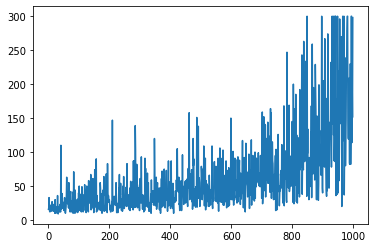

In [10]:
plt.plot(reward_list)
plt.show()